In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy as stats
#from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, kruskal
#from statsmodels.stats.multitest import fdrcorrection
import pingouin as pg
#import networkx as nx
from importlib.metadata import version

# set rcParams to be able to easily edit text in illustrator
plt.rcParams['pdf.fonttype'] = 42
sns.set_context("notebook", font_scale=1.5)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'  
plt.rcParams['font.sans-serif'] = ['Arial']  

# versions

In [2]:
print(f"pandas version: {version('pandas')}")
print(f"matplot.pyplot version: {version('matplotlib')}")
print(f"seaborn version: {version('seaborn')}")
print(f"numpy version: {version('numpy')}")
print(f"pingouin version: {version('pingouin')}")
#print(f"scipy version: {version('scipy')}")
#print(f"statsmodels version: {version('statsmodels')}")
#print(f"networkx version: {version('networkx')}")


pandas version: 2.2.1
matplot.pyplot version: 3.8.4
seaborn version: 0.12.2
numpy version: 1.26.4
pingouin version: 0.5.4


# load in data

In [3]:

# load in fisher functional connectivity matrices 
# these matrices have the white matter removed
# also, these subject ids have been removed: 
# PND30: exclude_animals = ['COMR332f', 'COMR332d', 'COMR311h', 'COMR302c', 'COMR381e']
# PND90: exclude_animals = ['COMR431c', 'COMR311h', 'COMR381g'] + COMR431d since one EPI direction was not acquired and it was not processed
fisher_matrices_dir = "/Users/hannalemmik/Dropbox/KO_paper/func/data/fisher_matrices"
#metadata_dir = "/Users/hannalemmik/Dropbox/KO_paper/func/data/metadata"

# PND30 matrices
cleaned_matrices_30 = []
subject_ids_30 = []

for file in glob.glob(os.path.join(fisher_matrices_dir, "*_fisher_PND30.csv")):
    df = pd.read_csv(file)
    cleaned_matrices_30.append(df)
    subject_id = os.path.basename(file).split('_')[0]  # extract subject ids from filename
    subject_ids_30.append(subject_id)
print(f"loaded {len(cleaned_matrices_30)} PND30 matrices.")

# PND90 matrices
cleaned_matrices_90 = []
subject_ids_90 = []

for file in glob.glob(os.path.join(fisher_matrices_dir, "*_fisher_PND90.csv")):
    df = pd.read_csv(file)
    cleaned_matrices_90.append(df)
    subject_id = os.path.basename(file).split('_')[0]  # extract subject ids from filename
    subject_ids_90.append(subject_id)
print(f"loaded {len(cleaned_matrices_90)} PND90 matrices.")


loaded 64 PND30 matrices.
loaded 65 PND90 matrices.


In [4]:
# load in original LONGC3 metadata
gens_path = '/Users/hannalemmik/Dropbox/LONGC3/gens.xlsx'
gens = pd.read_excel(gens_path) 

In [5]:
# extract a list of subject ids from file names

data_dir = "/Users/hannalemmik/Dropbox/KO_paper/func/data/fisher_matrices"
files = glob.glob(os.path.join(data_dir, "*_fisher_PND30.csv")) #find all PND30 files
subject_ids_30 = []
for file in files: # files defined above
    filename = os.path.basename(file)  # get just filename
    # split by 'sub-' and '_' to get the ID
    id_part = filename.split('_')[0]
    subject_ids_30.append(id_part)

subject_ids_30[:5]

['COMR291i', 'COMR232e', 'COMR332e', 'COMR421c', 'COMR431d']

In [6]:
# extract a list of subject ids from file names

data_dir = "/Users/hannalemmik/Dropbox/KO_paper/func/data/fisher_matrices"
files = glob.glob(os.path.join(data_dir, "*_fisher_PND90.csv")) #find all PND90 files
subject_ids_90 = []
for file in files: # files defined above
    filename = os.path.basename(file)  # get just filename
    # split by 'sub-' and '_' to get the ID
    id_part = filename.split('_')[0]
    subject_ids_90.append(id_part)

subject_ids_90[:5]

['COMR332d', 'COMR232d', 'COMR291h', 'COMR194c', 'COMR391c']

In [7]:
# match subject id with genotype
genotypes_30 = []
for subject in subject_ids_30:
    genotype = gens[gens['Animal_ID'] == subject]['Genotype'].iloc[0]
    genotypes_30.append(genotype)
genotypes_30[:5]

['KO', 'KO', 'KO', 'KO', 'KO']

In [8]:
# match subject id with genotype
genotypes_90 = []
for subject in subject_ids_90:
    genotype = gens[gens['Animal_ID'] == subject]['Genotype'].iloc[0]
    genotypes_90.append(genotype)
genotypes_90[:5]

['WT', 'KO', 'WT', 'WT', 'KO']

In [9]:
# match subject id with sex
sexes_30 = []
for subject in subject_ids_30:
    sex = gens[gens['Animal_ID'] == subject]['Sex'].iloc[0]
    sexes_30.append(sex)
sexes_30[:5]

['F', 'M', 'M', 'M', 'M']

In [10]:
# match subject id with sex
sexes_90 = []
for subject in subject_ids_90:
    sex = gens[gens['Animal_ID'] == subject]['Sex'].iloc[0]
    sexes_90.append(sex)
sexes_90[:5]

['M', 'M', 'F', 'M', 'M']

# check if metadata aligns with filenames/matrices order

In [11]:
# checking a few to see if metadata aligns
# print first 5 files and their corresponding subject IDs to verify matching

data_dir = "/Users/hannalemmik/Dropbox/KO_paper/func/data/fisher_matrices"
files = glob.glob(os.path.join(data_dir, "*_fisher_PND30.csv")) #find all PND30 files
print("filename vs extracted subject id vs genotype")
print("+" * 80)
for i in range(5):
    print(f"file: {os.path.basename(files[i])}")
    print(f"ID: {subject_ids_30[i]}")
    print(f"genotype: {genotypes_30[i]}")
    print(f"sex: {sexes_30[i]}")
    print("-" * 80)

filename vs extracted subject id vs genotype
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
file: COMR291i_fisher_PND30.csv
ID: COMR291i
genotype: KO
sex: F
--------------------------------------------------------------------------------
file: COMR232e_fisher_PND30.csv
ID: COMR232e
genotype: KO
sex: M
--------------------------------------------------------------------------------
file: COMR332e_fisher_PND30.csv
ID: COMR332e
genotype: KO
sex: M
--------------------------------------------------------------------------------
file: COMR421c_fisher_PND30.csv
ID: COMR421c
genotype: KO
sex: M
--------------------------------------------------------------------------------
file: COMR431d_fisher_PND30.csv
ID: COMR431d
genotype: KO
sex: M
--------------------------------------------------------------------------------


In [12]:
# check if the metadata is correct from the original LONGC3 datasheet
target_ids = ['COMR291i', 'COMR232e', 'COMR332e', 'COMR421c', 'COMR431d']
filtered_gens = gens[gens['Animal_ID'].isin(target_ids)]
filtered_gens = filtered_gens[['Animal_ID', 'Genotype', 'Sex']]
filtered_gens


,Animal_ID,Genotype,Sex
9,COMR291i,KO,F
36,COMR232e,KO,M
54,COMR332e,KO,M
62,COMR431d,KO,M
67,COMR421c,KO,M


In [13]:
# checking a few to see if metadata aligns
# print first 5 files and their corresponding subject IDs to verify matching

data_dir = "/Users/hannalemmik/Dropbox/KO_paper/func/data/fisher_matrices"
files = glob.glob(os.path.join(data_dir, "*_fisher_PND90.csv")) #find all PND90 files
print("filename vs extracted subject id vs genotype")
print("+" * 80)
for i in range(5):
    print(f"file: {os.path.basename(files[i])}")
    print(f"ID: {subject_ids_90[i]}")
    print(f"genotype: {genotypes_90[i]}")
    print(f"sex: {sexes_90[i]}")
    print("-" * 80)

filename vs extracted subject id vs genotype
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
file: COMR332d_fisher_PND90.csv
ID: COMR332d
genotype: WT
sex: M
--------------------------------------------------------------------------------
file: COMR232d_fisher_PND90.csv
ID: COMR232d
genotype: KO
sex: M
--------------------------------------------------------------------------------
file: COMR291h_fisher_PND90.csv
ID: COMR291h
genotype: WT
sex: F
--------------------------------------------------------------------------------
file: COMR194c_fisher_PND90.csv
ID: COMR194c
genotype: WT
sex: M
--------------------------------------------------------------------------------
file: COMR391c_fisher_PND90.csv
ID: COMR391c
genotype: KO
sex: M
--------------------------------------------------------------------------------


In [14]:
# check if the metadata is correct from the original LONGC3 datasheet
target_ids = ['COMR332d', 'COMR232d', 'COMR291h', 'COMR194c', 'COMR391c']
filtered_gens = gens[gens['Animal_ID'].isin(target_ids)]
filtered_gens = filtered_gens[['Animal_ID', 'Genotype', 'Sex']]
filtered_gens

,Animal_ID,Genotype,Sex
8,COMR291h,WT,F
35,COMR232d,KO,M
43,COMR194c,WT,M
53,COMR332d,WT,M
65,COMR391c,KO,M


# anxiety-related seed mean fc 

In [15]:
roi_labels_30 = cleaned_matrices_30[0].columns.tolist()
roi_labels_90 = cleaned_matrices_90[0].columns.tolist()

In [16]:
# define a priori ROIs related to anxiety
apriori_rois = ['L_prefrontal_cx',
                'L_amygdala',
                'L_striatum',
                'L_hypothalamus',
                'L_dorsal_hippocampus',
                'L_pallidum_acc',
                'L_ventral_hippocampus',
                'L_pag',
                'L_cingulate_cx',
                'L_brain_stem',
                'R_brain_stem',
                'R_cingulate_cx',
                'R_pag',
                'R_ventral_hippocampus',
                'R_dorsal_hippocampus',
                'R_hypothalamus',
                'R_striatum',
                'R_amygdala',
                'R_pallidum_acc',
                'R_prefrontal_cx',
                'R_cingulate_cx'
]



In [17]:
results_30 = {}

# process each matrix (each animal)
for idx, matrix in enumerate(cleaned_matrices_30):
    subject_id = subject_ids_30[idx]
    results_30[subject_id] = {}
    
    # for each a priori ROI
    for roi in apriori_rois:
        if roi in roi_labels_30:  
            # get the index of this ROI in roi_labels
            roi_idx = roi_labels_30.index(roi)
            # get all connections except self-connection
            connections = matrix.iloc[roi_idx, :].copy()
            connections = np.delete(connections, roi_idx)  # remove self-connection
            # calculate average connectivity
            avg_connectivity = np.mean(connections)
            # store
            results_30[subject_id][f'{roi}'] = avg_connectivity

# convert to pandas df and add genotype
df_results_30 = pd.DataFrame.from_dict(results_30, orient='index')
df_results_30['genotype'] = pd.Series(dict(zip(subject_ids_30, genotypes_30)))
df_results_30['sex'] = pd.Series(dict(zip(subject_ids_30, sexes_30)))
df_results_30.head()

,L_prefrontal_cx,L_amygdala,L_striatum,L_hypothalamus,L_dorsal_hippocampus,L_pallidum_acc,L_ventral_hippocampus,L_pag,L_cingulate_cx,L_brain_stem,...,R_pag,R_ventral_hippocampus,R_dorsal_hippocampus,R_hypothalamus,R_striatum,R_amygdala,R_pallidum_acc,R_prefrontal_cx,genotype,sex
COMR291i,0.328677,0.208385,0.263043,0.169728,0.350336,0.234311,0.177678,0.238949,0.365816,0.032956,...,0.211621,0.155606,0.362061,0.212171,0.168616,0.156333,0.241133,0.256027,KO,F
COMR232e,0.173662,0.087564,0.150628,0.164495,0.282767,0.148018,0.104260,0.209572,0.162483,0.067213,...,0.185261,0.104836,0.253113,0.130201,0.216955,0.091917,0.137630,0.210752,KO,M
COMR332e,0.339743,0.262510,0.375998,0.412020,0.568355,0.241116,0.363964,0.516464,0.430997,0.337773,...,0.502224,0.368486,0.556872,0.361932,0.361678,0.353907,0.171090,0.340403,KO,M
COMR421c,0.282221,0.120438,0.206317,0.252825,0.377158,0.167192,0.114803,0.247137,0.323589,0.088623,...,0.271754,0.262644,0.394918,0.232152,0.247743,0.118381,0.169091,0.274314,KO,M
COMR431d,0.289255,0.095743,0.199320,0.291583,0.259951,0.198858,0.198784,0.335197,0.318022,0.112347,...,0.299420,0.266376,0.329617,0.258550,0.063990,0.077807,0.158620,0.285326,KO,M


In [18]:
# checking first animal to make sure it's correct
# check if true
subject_ids_30[0]

'COMR291i'

In [19]:
# testing if I get the same mean for fist animal
test=cleaned_matrices_30[0]
# get L_prefrontal_cx row
row = test.loc[1, :]  # since L_prefrontal_cx appears to be in row 1
# remove self-connection (where it connects to itself)
row_no_self = row[row.index != 'L_prefrontal_cx']
# calculate mean
mean = row_no_self.mean()

# output should vbe L_prefrontal_cx value for COMR291i
mean 

0.3286767462735871

In [20]:
results_90 = {}

# process each matrix (each animal)
for idx, matrix in enumerate(cleaned_matrices_90):
    subject_id = subject_ids_90[idx]
    results_90[subject_id] = {}
    
    # for each a priori ROI
    for roi in apriori_rois:
        if roi in roi_labels_90: 
            # get the index of this ROI
            roi_idx = roi_labels_90.index(roi)
            # get all connections except self-connection
            connections = matrix.iloc[roi_idx, :].copy()
            connections = np.delete(connections, roi_idx)  # remove self-connection
            # calculate average connectivity
            avg_connectivity = np.mean(connections)
            # store
            results_90[subject_id][f'{roi}'] = avg_connectivity

# convert to pandas df and add genotype
df_results_90 = pd.DataFrame.from_dict(results_90, orient='index')
df_results_90['genotype'] = pd.Series(dict(zip(subject_ids_90, genotypes_90)))
df_results_90['sex'] = pd.Series(dict(zip(subject_ids_90, sexes_90)))
df_results_90.head()

,L_prefrontal_cx,L_amygdala,L_striatum,L_hypothalamus,L_dorsal_hippocampus,L_pallidum_acc,L_ventral_hippocampus,L_pag,L_cingulate_cx,L_brain_stem,...,R_pag,R_ventral_hippocampus,R_dorsal_hippocampus,R_hypothalamus,R_striatum,R_amygdala,R_pallidum_acc,R_prefrontal_cx,genotype,sex
COMR332d,0.042182,0.360492,0.396914,0.418265,0.496508,0.321503,0.206890,0.226338,0.383453,0.241501,...,0.238167,0.262715,0.520162,0.426497,0.437331,0.405092,0.442115,0.028356,WT,M
COMR232d,0.362368,0.221297,0.309428,0.297701,0.462562,0.185745,0.180932,0.338977,0.432606,0.138670,...,0.306661,0.237359,0.464646,0.335072,0.245024,0.141127,0.257247,0.316453,KO,M
COMR291h,0.383950,0.162632,0.331336,0.266713,0.331150,0.246606,0.100851,0.159428,0.450950,0.090185,...,0.153113,0.227533,0.382547,0.226411,0.331068,0.182859,0.277177,0.395723,WT,F
COMR194c,0.663584,0.361899,0.508007,0.594976,0.741928,0.486470,0.422429,0.536468,0.769893,0.247845,...,0.477338,0.330169,0.718647,0.525307,0.449589,0.252969,0.443508,0.637271,WT,M
COMR391c,0.270268,0.182851,0.351425,0.224835,0.444798,0.279103,0.237955,0.330507,0.426908,0.201095,...,0.307307,0.196799,0.435078,0.237291,0.368862,0.192032,0.282327,0.338954,KO,M


In [21]:
len(df_results_90.index.unique())


65

/var/folders/r9/_1bw8v7j4dqb79r_rydnls7c0000gn/T/ipykernel_20265/549012103.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


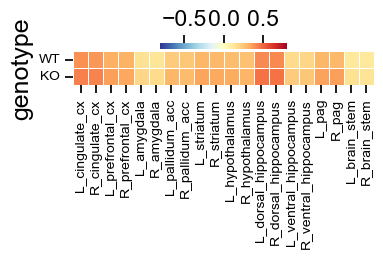

In [22]:
# remove metadata columns and get just the connectivity columns
connectivity_cols = [col for col in df_results_30.columns if col not in ['genotype', 'sex']]

# calculate mean values for each ROI by genotype 
mean_by_genotype = df_results_30.groupby('genotype')[connectivity_cols].mean().reindex(['WT', 'KO'])

desired_order = ['L_cingulate_cx', 'R_cingulate_cx',
                'L_prefrontal_cx', 'R_prefrontal_cx',
                'L_amygdala', 'R_amygdala',
                'L_pallidum_acc','R_pallidum_acc',
                'L_striatum', 'R_striatum',
                'L_hypothalamus', 'R_hypothalamus',
                'L_dorsal_hippocampus', 'R_dorsal_hippocampus',
                'L_ventral_hippocampus', 'R_ventral_hippocampus',
                'L_pag', 'R_pag',
                'L_brain_stem', 'R_brain_stem']

mean_by_genotype_ordered = mean_by_genotype.loc[:, desired_order]

# plot
plt.figure(figsize=(4, 2.6))

# heatmap with transposed data
ax = sns.heatmap(mean_by_genotype_ordered,
                cmap='RdYlBu_r',
                center=0,
                xticklabels=desired_order,
                annot=False,
                linewidth=.5,
                cbar_kws={ 'orientation':'horizontal', 'location': 'top'},
                vmin=-0.8,
                vmax=0.8)

ax.tick_params(labelsize=10)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('')
plt.tight_layout()
plt.savefig("/Users/hannalemmik/Dropbox/KO_paper/func/plots/apriori_30.pdf")

/var/folders/r9/_1bw8v7j4dqb79r_rydnls7c0000gn/T/ipykernel_20265/212338306.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


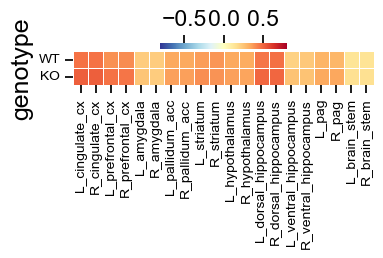

In [23]:
# remove metadata columns and get just the connectivity columns
connectivity_cols = [col for col in df_results_90.columns if col not in ['genotype', 'sex']]

# calculate mean values for each ROI by genotype 
mean_by_genotype = df_results_90.groupby('genotype')[connectivity_cols].mean().reindex(['WT', 'KO'])

desired_order = ['L_cingulate_cx', 'R_cingulate_cx',
                'L_prefrontal_cx', 'R_prefrontal_cx',
                'L_amygdala', 'R_amygdala',
                'L_pallidum_acc','R_pallidum_acc',
                'L_striatum', 'R_striatum',
                'L_hypothalamus', 'R_hypothalamus',
                'L_dorsal_hippocampus', 'R_dorsal_hippocampus',
                'L_ventral_hippocampus', 'R_ventral_hippocampus',
                'L_pag', 'R_pag',
                'L_brain_stem', 'R_brain_stem']

mean_by_genotype_ordered = mean_by_genotype.loc[:, desired_order]

# plot
plt.figure(figsize=(4, 2.6))

# heatmap with transposed data
ax = sns.heatmap(mean_by_genotype_ordered,
                cmap='RdYlBu_r',
                center=0,
                xticklabels=desired_order,
                annot=False,
                linewidth=.5,
                cbar_kws={ 'orientation':'horizontal', 'location': 'top'},
                vmin=-0.8,
                vmax=0.8)

ax.tick_params(labelsize=10)
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('')
plt.tight_layout()
plt.savefig("/Users/hannalemmik/Dropbox/KO_paper/func/plots/apriori_90.pdf")

# stats for a priori rois with mixed ANOVA using pingouin
https://pingouin-stats.org/build/html/generated/pingouin.mixed_anova.html

In [24]:
df_long_30 = df_results_30.reset_index()
df_long_30 = df_long_30.rename(columns={'index': 'subject_id'})

df_long_melted_30 = df_long_30.melt(id_vars=['subject_id','genotype','sex'], 
                             var_name='roi', 
                             value_name='mean_fc')

df_long_melted_30

,subject_id,genotype,sex,roi,mean_fc
0,COMR291i,KO,F,L_prefrontal_cx,0.328677
1,COMR232e,KO,M,L_prefrontal_cx,0.173662
2,COMR332e,KO,M,L_prefrontal_cx,0.339743
3,COMR421c,KO,M,L_prefrontal_cx,0.282221
4,COMR431d,KO,M,L_prefrontal_cx,0.289255
...,...,...,...,...,...
1275,COMR301c,KO,M,R_prefrontal_cx,0.258978
1276,COMR233f,WT,M,R_prefrontal_cx,0.613851
1277,COMR194e,KO,F,R_prefrontal_cx,0.197904
1278,COMR291e,WT,F,R_prefrontal_cx,0.300357


In [25]:
df_long_90 = df_results_90.reset_index()
df_long_90 = df_long_90.rename(columns={'index': 'subject_id'})

df_long_melted_90 = df_long_90.melt(id_vars=['subject_id','genotype','sex'], 
                             var_name='roi', 
                             value_name='mean_fc')

df_long_melted_90

,subject_id,genotype,sex,roi,mean_fc
0,COMR332d,WT,M,L_prefrontal_cx,0.042182
1,COMR232d,KO,M,L_prefrontal_cx,0.362368
2,COMR291h,WT,F,L_prefrontal_cx,0.383950
3,COMR194c,WT,M,L_prefrontal_cx,0.663584
4,COMR391c,KO,M,L_prefrontal_cx,0.270268
...,...,...,...,...,...
1295,COMR381h,WT,F,R_prefrontal_cx,0.323444
1296,COMR221a,KO,M,R_prefrontal_cx,0.433280
1297,COMR194d,KO,F,R_prefrontal_cx,0.274768
1298,COMR321a,WT,M,R_prefrontal_cx,0.464027


In [26]:
aov = pg.mixed_anova(data=df_long_melted_30, 
                     dv='mean_fc', 
                     between='genotype',
                     within='roi',
                     subject='subject_id')

aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,genotype,0.683040,1,62,0.683040,2.778400,1.005880e-01,0.042891,NaN
1,roi,11.298785,19,1178,0.594673,139.639776,2.942874e-285,0.692521,0.35201
2,Interaction,0.032423,19,1178,0.001706,0.400713,9.899107e-01,0.006422,NaN


In [27]:
aov = pg.mixed_anova(data=df_long_melted_90, 
                     dv='mean_fc', 
                     between='genotype',
                     within='roi',
                     subject='subject_id')

aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,genotype,0.330491,1,63,0.330491,0.997202,0.321809,0.015582,NaN
1,roi,14.842877,19,1197,0.781204,172.045385,0.000000,0.731967,0.336762
2,Interaction,0.088265,19,1197,0.004646,1.023094,0.430257,0.015980,NaN


# checking distribution of datapoints of a subset of a priori rois

In [28]:
# create a pandas df with PND30 subject ids
# this step is necessary since unequal number of ids has been excluded from both timepoints
df_subjects = pd.DataFrame({'subject_id': subject_ids_30})

# find missing subject ids from PND90 and add them to the df
missing_subjects_90 = set(subject_ids_90) - set(subject_ids_30)
for subject in missing_subjects_90:
    df_subjects = pd.concat([df_subjects, pd.DataFrame({'subject_id': [subject]})], ignore_index=True)

df_subjects.head(1)


,subject_id
0,COMR291i


In [29]:
# merge df_results_30 onto df_subjects using subject_id as the key
df_combined_30 = df_subjects.merge(df_results_30, left_on='subject_id', right_index=True, how='left')

# fill missing values a placeholder
df_combined_30.fillna('NA', inplace=True)

df_combined_30.tail()


/var/folders/r9/_1bw8v7j4dqb79r_rydnls7c0000gn/T/ipykernel_20265/272023935.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_combined_30.fillna('NA', inplace=True)


,subject_id,L_prefrontal_cx,L_amygdala,L_striatum,L_hypothalamus,L_dorsal_hippocampus,L_pallidum_acc,L_ventral_hippocampus,L_pag,L_cingulate_cx,...,R_pag,R_ventral_hippocampus,R_dorsal_hippocampus,R_hypothalamus,R_striatum,R_amygdala,R_pallidum_acc,R_prefrontal_cx,genotype,sex
63,COMR431c,0.147126,0.10174,0.289059,0.266116,0.423239,0.299914,0.197003,0.236282,0.388336,...,0.302682,0.203358,0.403693,0.248587,0.301431,0.112119,0.298665,0.136286,WT,F
64,COMR381e,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
65,COMR332d,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
66,COMR302c,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
67,COMR332f,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [30]:
# merge df_results_90 onto df_subjects using subject_id as the key
df_combined_90 = df_subjects.merge(df_results_90, left_on='subject_id', right_index=True, how='left')

# fill missing values a placeholder
df_combined_90.fillna('NA', inplace=True)

df_combined_90.tail()

/var/folders/r9/_1bw8v7j4dqb79r_rydnls7c0000gn/T/ipykernel_20265/1691958361.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_combined_90.fillna('NA', inplace=True)


,subject_id,L_prefrontal_cx,L_amygdala,L_striatum,L_hypothalamus,L_dorsal_hippocampus,L_pallidum_acc,L_ventral_hippocampus,L_pag,L_cingulate_cx,...,R_pag,R_ventral_hippocampus,R_dorsal_hippocampus,R_hypothalamus,R_striatum,R_amygdala,R_pallidum_acc,R_prefrontal_cx,genotype,sex
63,COMR431c,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
64,COMR381e,0.23958,0.106316,0.223621,0.129271,0.196218,0.195828,0.037134,0.131394,0.211085,...,0.105694,0.116242,0.230894,0.136831,0.218935,0.121316,0.166944,0.29513,WT,M
65,COMR332d,0.042182,0.360492,0.396914,0.418265,0.496508,0.321503,0.20689,0.226338,0.383453,...,0.238167,0.262715,0.520162,0.426497,0.437331,0.405092,0.442115,0.028356,WT,M
66,COMR302c,0.402381,0.144284,0.291005,0.12481,0.279929,0.213509,0.14266,0.145203,0.358858,...,0.127159,0.111421,0.249665,0.149248,0.276318,0.088604,0.200804,0.394488,KO,F
67,COMR332f,0.391426,0.210116,0.275818,0.319286,0.465881,0.317462,0.156232,0.266465,0.408749,...,0.222225,0.064481,0.444416,0.30018,0.26232,0.162883,0.309981,0.356425,WT,F


In [31]:
selected_rois = [
    'L_amygdala',
    'R_amygdala',
    'L_dorsal_hippocampus',
    'R_dorsal_hippocampus',
    'L_ventral_hippocampus',
    'R_ventral_hippocampus'
]

/opt/anaconda3/envs/python3119/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/python3119/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


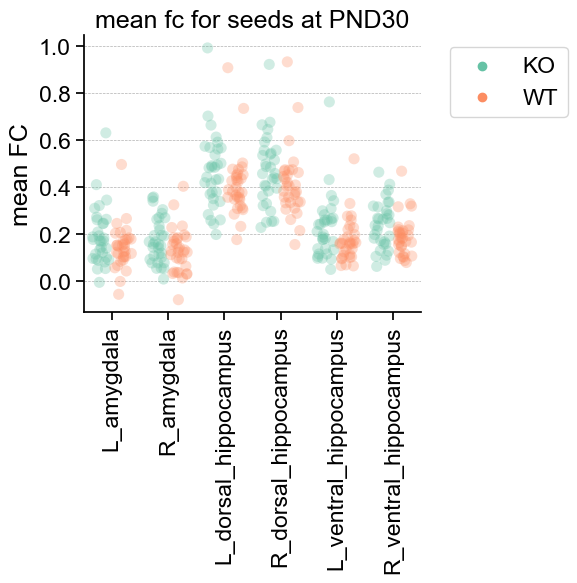

In [32]:
# plotting a few seleceted ROIs
df_filtered_30 = df_combined_30[['subject_id', 'genotype', 'sex'] + selected_rois].replace('NA', pd.NA).dropna(subset=selected_rois)
df_long_30 = df_filtered_30.melt(
    id_vars=['subject_id', 'genotype', 'sex'],
    value_vars=selected_rois,
    var_name='ROI',
    value_name='mean_FC'
)

# seaborn strip plot
plt.figure(figsize=(6, 6))
sns.stripplot(
    data=df_long_30, 
    x='ROI', 
    y='mean_FC', 
    hue='genotype', 
    dodge=True, 
    jitter=0.3, 
    alpha=0.3,
    size=8, 
    palette='Set2'
)

# Customize the plot
plt.title('mean fc for seeds at PND30')
plt.xlabel('')
plt.ylabel('mean FC')
plt.xticks(rotation=90)
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()




/opt/anaconda3/envs/python3119/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/python3119/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


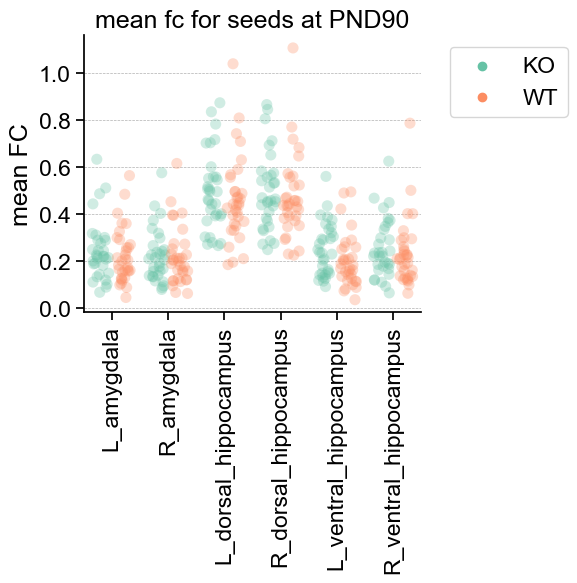

In [33]:
df_filtered_90 = df_combined_90[['subject_id', 'genotype', 'sex'] + selected_rois].replace('NA', pd.NA).dropna(subset=selected_rois)
df_long_90 = df_filtered_90.melt(
    id_vars=['subject_id', 'genotype', 'sex'],
    value_vars=selected_rois,
    var_name='ROI',
    value_name='mean_FC'
)

# seaborn strip plot
plt.figure(figsize=(6, 6))
sns.stripplot(
    data=df_long_90, 
    x='ROI', 
    y='mean_FC', 
    hue='genotype', 
    dodge=True, 
    jitter=0.3, 
    alpha=0.3,
    size=8, 
    palette='Set2'
)

# Customize the plot
plt.title('mean fc for seeds at PND90')
plt.xlabel('')
plt.ylabel('mean FC')
plt.xticks(rotation=90)
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()




In [34]:
df_combined_90.head()

,subject_id,L_prefrontal_cx,L_amygdala,L_striatum,L_hypothalamus,L_dorsal_hippocampus,L_pallidum_acc,L_ventral_hippocampus,L_pag,L_cingulate_cx,...,R_pag,R_ventral_hippocampus,R_dorsal_hippocampus,R_hypothalamus,R_striatum,R_amygdala,R_pallidum_acc,R_prefrontal_cx,genotype,sex
0,COMR291i,0.653683,0.311598,0.569509,0.417814,0.601453,0.470163,0.388998,0.319504,0.641023,...,0.376114,0.365061,0.583807,0.474163,0.473736,0.242818,0.4581,0.634085,KO,F
1,COMR232e,0.526401,0.213236,0.457158,0.323271,0.516882,0.418274,0.305537,0.31449,0.613255,...,0.346148,0.222318,0.557276,0.383215,0.418864,0.173988,0.362381,0.555847,KO,M
2,COMR332e,0.236601,0.221129,0.266838,0.180668,0.272385,0.232403,0.142258,0.139457,0.28098,...,0.148062,0.121262,0.273033,0.159637,0.278138,0.136031,0.214483,0.275359,KO,M
3,COMR421c,0.285476,0.149819,0.24816,0.207977,0.2668,0.164462,0.156102,0.176219,0.389395,...,0.183111,0.144882,0.336941,0.207285,0.311642,0.156934,0.244423,0.349036,KO,M
4,COMR431d,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [35]:
# making ∆ df so need to exclude all animals who don't have two datapoints
exclude_all= ['COMR332f', 
            'COMR332d',  
            'COMR302c', 
            'COMR381e', 
            'COMR431c', 
            'COMR311h', 
            'COMR381g',
        	'COMR431d'  #exclude this too since it was never processed - no data
            ]

# remove rows with subject_id in exclude lists
df_combined_30 = df_combined_30[~df_combined_30['subject_id'].isin(exclude_all)]
df_combined_90 = df_combined_90[~df_combined_90['subject_id'].isin(exclude_all)]




In [36]:
df_combined_90

,subject_id,L_prefrontal_cx,L_amygdala,L_striatum,L_hypothalamus,L_dorsal_hippocampus,L_pallidum_acc,L_ventral_hippocampus,L_pag,L_cingulate_cx,...,R_pag,R_ventral_hippocampus,R_dorsal_hippocampus,R_hypothalamus,R_striatum,R_amygdala,R_pallidum_acc,R_prefrontal_cx,genotype,sex
0,COMR291i,0.653683,0.311598,0.569509,0.417814,0.601453,0.470163,0.388998,0.319504,0.641023,...,0.376114,0.365061,0.583807,0.474163,0.473736,0.242818,0.4581,0.634085,KO,F
1,COMR232e,0.526401,0.213236,0.457158,0.323271,0.516882,0.418274,0.305537,0.31449,0.613255,...,0.346148,0.222318,0.557276,0.383215,0.418864,0.173988,0.362381,0.555847,KO,M
2,COMR332e,0.236601,0.221129,0.266838,0.180668,0.272385,0.232403,0.142258,0.139457,0.28098,...,0.148062,0.121262,0.273033,0.159637,0.278138,0.136031,0.214483,0.275359,KO,M
3,COMR421c,0.285476,0.149819,0.24816,0.207977,0.2668,0.164462,0.156102,0.176219,0.389395,...,0.183111,0.144882,0.336941,0.207285,0.311642,0.156934,0.244423,0.349036,KO,M
5,COMR301d,0.551692,0.271,0.466696,0.487824,0.590202,0.378599,0.354002,0.52253,0.675584,...,0.521131,0.402249,0.57217,0.499181,0.513307,0.336247,0.422242,0.580063,WT,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,COMR341e,0.552869,0.250234,0.410591,0.587287,0.702182,0.359136,0.294715,0.500183,0.686032,...,0.49955,0.348491,0.693234,0.51312,0.391987,0.206653,0.429725,0.594646,KO,F
59,COMR301c,0.857741,0.486957,0.677954,0.691834,0.78259,0.752035,0.39716,0.721919,0.872663,...,0.823481,0.625123,0.865409,0.737486,0.71432,0.575972,0.775334,0.863113,KO,M
60,COMR233f,0.166998,0.130606,0.206016,0.107236,0.260127,0.150068,0.114091,0.14282,0.263793,...,0.171628,0.130424,0.292954,0.159961,0.209052,0.114211,0.132376,0.131655,WT,M
61,COMR194e,0.350328,0.221987,0.393826,0.299815,0.420321,0.246486,0.164965,0.249686,0.454289,...,0.272333,0.179379,0.453274,0.227968,0.41316,0.249304,0.273224,0.339071,KO,F


In [37]:
# calculate the delta (difference)
df_delta = df_combined_90[selected_rois] - df_combined_30[selected_rois]

# add back non-ROI columns
df_delta['genotype'] = df_combined_90['genotype']
df_delta['sex'] = df_combined_90['sex']
df_delta['subject_id'] = df_combined_90['subject_id']

df_delta

,L_amygdala,R_amygdala,L_dorsal_hippocampus,R_dorsal_hippocampus,L_ventral_hippocampus,R_ventral_hippocampus,genotype,sex,subject_id
0,0.103213,0.086486,0.251117,0.221745,0.21132,0.209455,KO,F,COMR291i
1,0.125673,0.082071,0.234114,0.304163,0.201277,0.117481,KO,M,COMR232e
2,-0.041381,-0.217875,-0.29597,-0.283839,-0.221706,-0.247223,KO,M,COMR332e
3,0.029381,0.038553,-0.110358,-0.057976,0.041299,-0.117762,KO,M,COMR421c
5,0.064319,0.151728,0.087916,0.098204,0.024069,0.195837,WT,F,COMR301d
...,...,...,...,...,...,...,...,...,...
58,0.197418,0.198559,0.379332,0.372583,0.245593,0.286518,KO,F,COMR341e
59,0.310262,0.382374,0.366651,0.42597,0.228939,0.434032,KO,M,COMR301c
60,-0.052738,-0.210099,-0.474676,-0.445654,-0.14529,-0.185496,WT,M,COMR233f
61,0.131918,0.196449,0.162586,0.20327,0.07167,0.091189,KO,F,COMR194e


/opt/anaconda3/envs/python3119/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/python3119/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


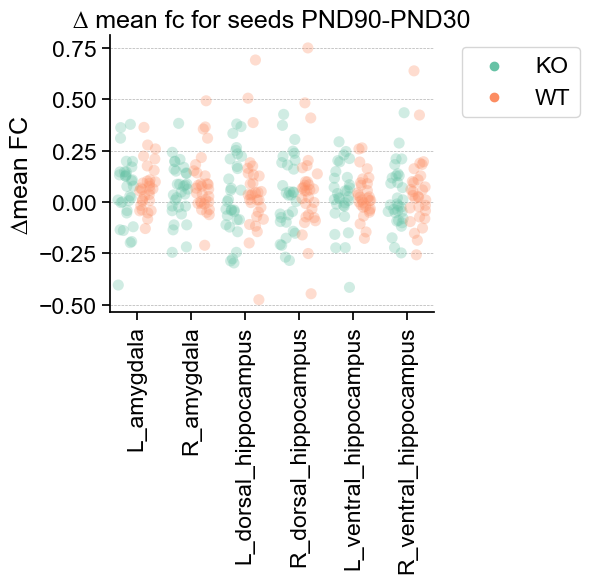

In [38]:
df_filtered_delta = df_delta[['subject_id', 'genotype', 'sex'] + selected_rois].replace('NA', pd.NA).dropna(subset=selected_rois)
df_delta = df_filtered_delta.melt(
    id_vars=['subject_id', 'genotype', 'sex'],
    value_vars=selected_rois,
    var_name='ROI',
    value_name='mean_FC'
)

# seaborn strip plot
plt.figure(figsize=(6, 6))
sns.stripplot(
    data=df_delta, 
    x='ROI', 
    y='mean_FC', 
    hue='genotype', 
    dodge=True, 
    jitter=0.3, 
    alpha=0.3,
    size=8, 
    palette='Set2'
)

# Customize the plot
plt.title('∆ mean fc for seeds PND90-PND30')
plt.xlabel('')
plt.ylabel('∆mean FC')
plt.xticks(rotation=90)
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()


